<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter1/1_3_%E8%BF%91%E4%BC%BC%E6%8E%A8%E8%AB%96%E6%89%8B%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Colaboratoryで実行する場合はこちらのリンクをクリックしてください。

In [1]:
#@title Import packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# マルコフ連鎖モンテカルロ法（MCMC) 

## マルコフ連鎖

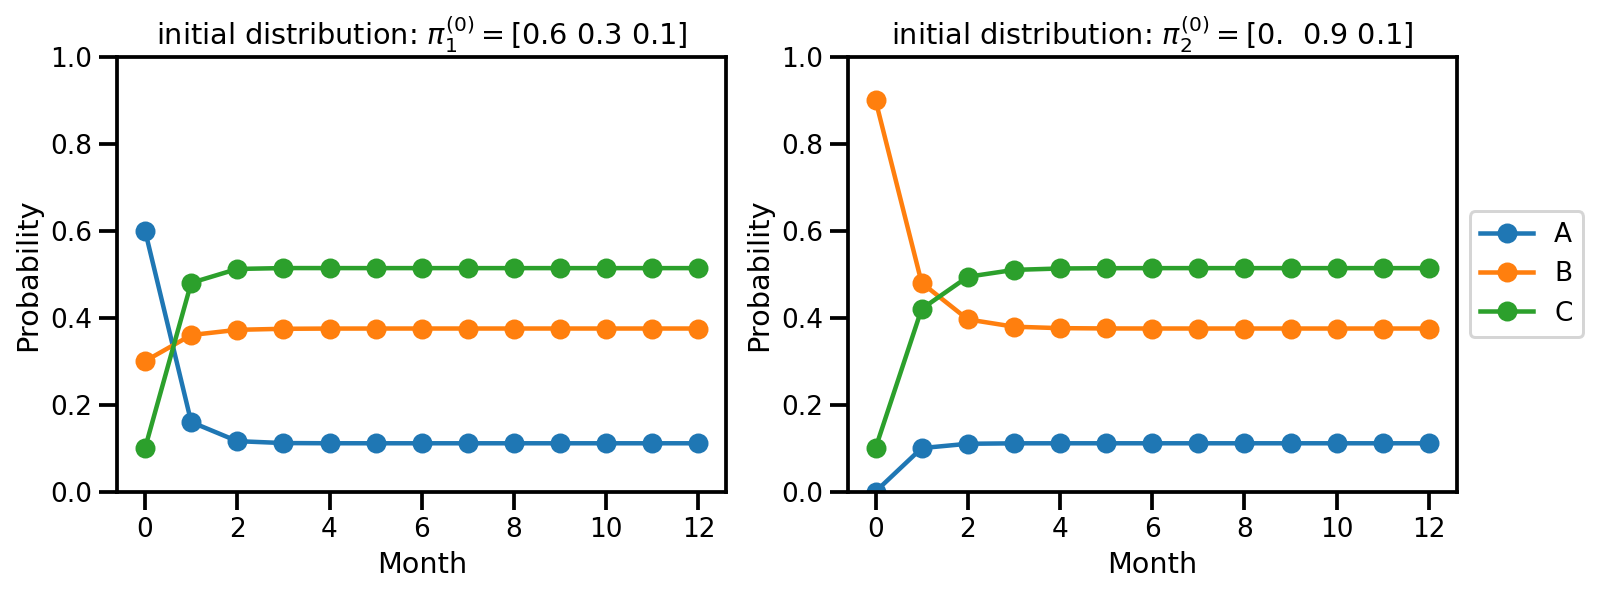

In [2]:
#@title Markov chain
# 遷移確率
T = np.array([[0.2, 0.3, 0.5], [0.1, 0.5, 0.4], [0.1, 0.3, 0.6]])

init_1 = np.array([0.6, 0.3, 0.1])
init_2 = np.array([0, 0.9, 0.1])

def plot_markov_chain(init, T, n_steps):
    res = [init]
    for j in range(n_steps):
        init = init @ T
        res.append(init)
    res = np.array(res)

    plt.plot(res[:, 0], marker='o', label='A')
    plt.plot(res[:, 1], marker='o', label='B')
    plt.plot(res[:, 2], marker='o', label='C')
    plt.ylim(0, 1)
    # plt.legend()

plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_markov_chain(init_1, T, 12)
plt.xlabel('Month')
plt.ylabel('Probability')
plt.title('initial distribution: $\pi^{(0)}_1=$' + f'{init_1}')

plt.subplot(122)
plot_markov_chain(init_2, T, 12)
plt.xlabel('Month')
plt.ylabel('Probability')
plt.title('initial distribution: $\pi^{(0)}_2=$' + f'{init_2}')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## モンテカルロ法

Text(0, 0.5, '$f(z)$')

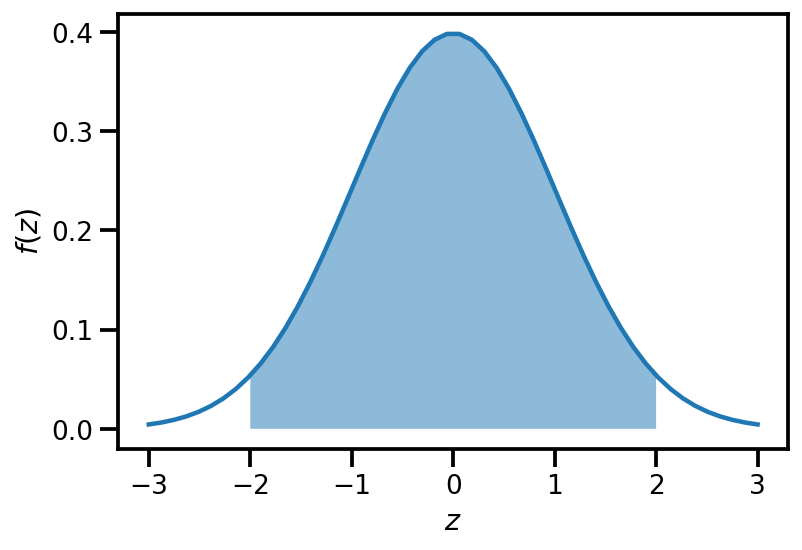

In [3]:
#@title 求めたい積分
from scipy import stats

xx = np.linspace(-3, 3)
plt.plot(xx, stats.norm(0, 1).pdf(xx))

xx = np.linspace(-2, 2)
plt.fill_between(xx, stats.norm(0, 1).pdf(xx), alpha=0.5)
plt.xlabel("$z$")
plt.ylabel("$f(z)$")

ground truth: 0.9545
M = 100, estimation: 0.9574 ± 0.0426
M = 1000, estimation: 0.9520 ± 0.0144
M = 10000, estimation: 0.9548 ± 0.0048
M = 100000, estimation: 0.9543 ± 0.0015


Text(0, 0.5, 'estimation')

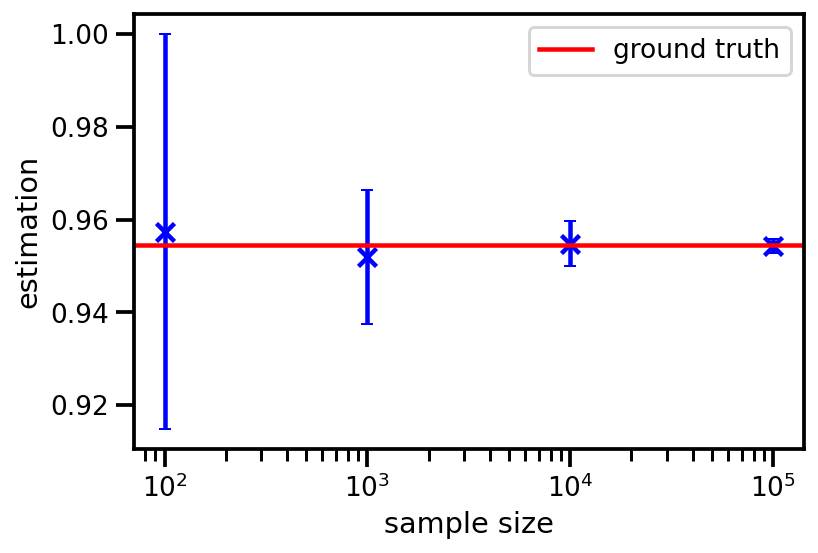

In [4]:
def montecarlo(M, trial=100, seed=1):
    """M個のサンプルによるモンテカルロ法をtrial回繰り返し、推定値の平均と標準偏差を返す"""
    np.random.seed(seed)
    x = np.random.uniform(-2, 2, (M, trial))
    res = 4 * stats.norm(0, 1).pdf(x).mean(axis=0)
    return res.mean(), res.std()


# 求めたい積分値の真の値
ground_truth = stats.norm(0, 1).cdf(2) - stats.norm(0, 1).cdf(-2)
print(f'ground truth: {ground_truth:.4f}')

M_list = [100, 1000, 10000, 100000]
fig, ax = plt.subplots()
for M in M_list:
    m, s = montecarlo(M)
    print(f'M = {M}, estimation: {m:.4f} ± {s:.4f}')
    ax.scatter(M, m, c='b', marker='x')
    ax.errorbar(M, m, s, capsize=3, c="b")
ax.axhline(ground_truth, c="r", label="ground truth")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("sample size")
ax.set_ylabel("estimation")

## MCMCの具体例

sample mean: 3.06, sample sd: 0.89


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'count')

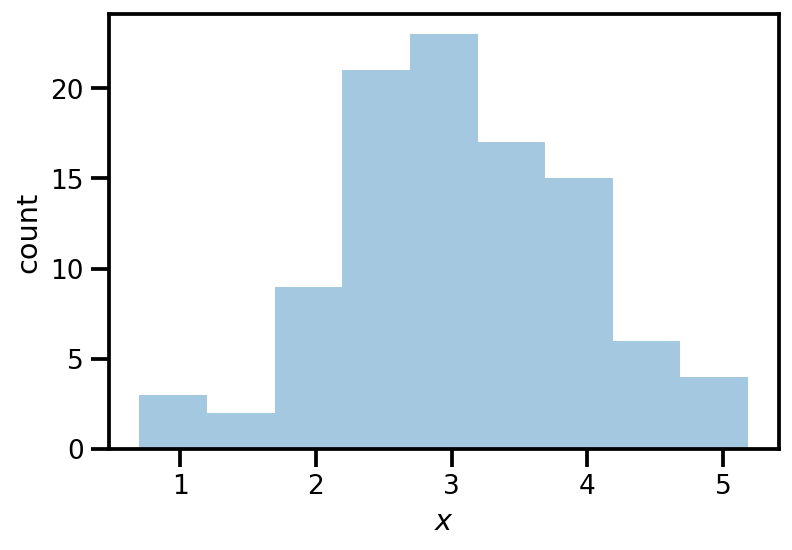

In [5]:
# パラメータの設定　
n_sample = 100
true_mean = 3.0
true_sd = 1.0

np.random.seed(1)

# シミュレーションデータの生成
data = np.random.normal(true_mean, true_sd, n_sample)
print('sample mean: {:.2f}, sample sd: {:.2f}'.format(data.mean(), data.std()))

sns.distplot(data, kde=False)
plt.xlabel('$x$')
plt.ylabel('count')

In [6]:
# メトロポリス法
n_iter = 6000
step_size = 0.3
x_init = 0.0

# 現在のサンプルの値
x_current = x_init
# サンプルを保存するリスト
posterior = []
# 提案分布からのサンプルが受容された回数
n_accepted = 0


def unnormalized_log_posterior(z):
    """正規化されていない事後分布 𝑝̃(𝐳) の計算"""
    likelihood = stats.norm(z, true_sd).logpdf(data).sum()
    prior = stats.norm(0, 10).logpdf(z)
    return prior + likelihood

In [7]:
np.random.seed(1)

for i in tqdm(range(n_iter)):
    # 撹乱項εは平均０の一様分布に従うとする
    x_proposal = x_current + step_size * np.random.uniform(-1, 1)

    logp_current = unnormalized_log_posterior(x_current)
    logp_proposal = unnormalized_log_posterior(x_proposal)
    # [0, 1]の一様分布からのサンプル
    r = np.random.rand()
    # メトロポリス・ヘイスティングス基準に従い、提案された値を受容するかどうか判定
    # logp_proposal > logp_currentなら必ず受容
    # logp_proposal < logp_currentの場合は、np.exp(logp_proposal - logp_current)の確率で受容
    if np.exp(logp_proposal - logp_current) > r:
        n_accepted += 1
        x_current = x_proposal
    posterior.append(x_current)

print('acceptance ratio: {:.3f}'.format(n_accepted / n_iter))

  0%|          | 0/6000 [00:00<?, ?it/s]

acceptance ratio: 0.489


Text(0, 0.5, '$z$')

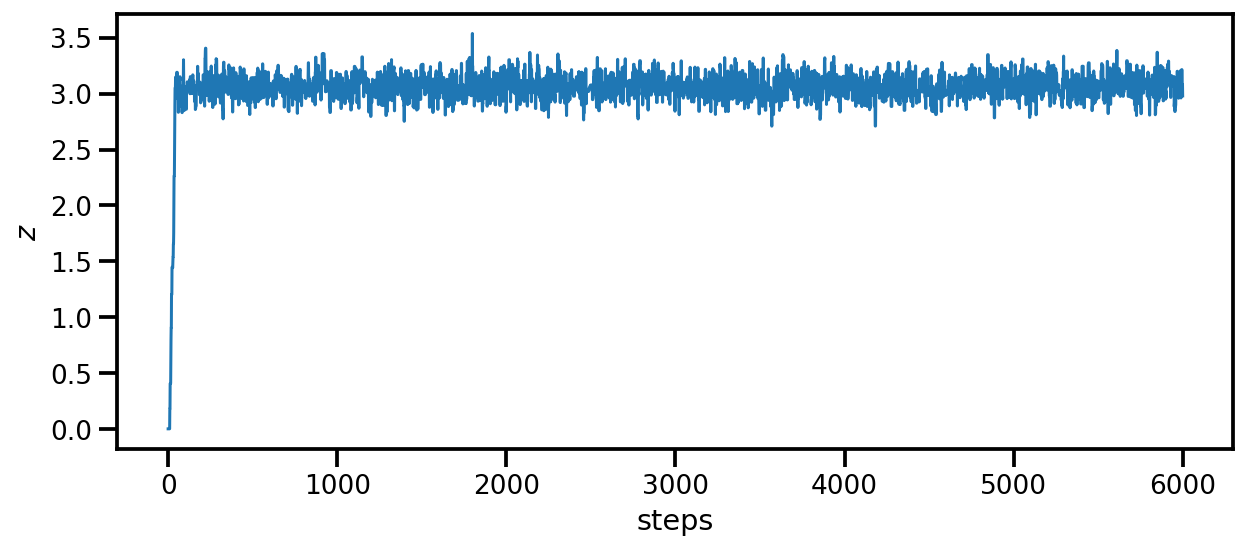

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(posterior, lw=1.5)
plt.xlabel('steps')
plt.ylabel('$z$')

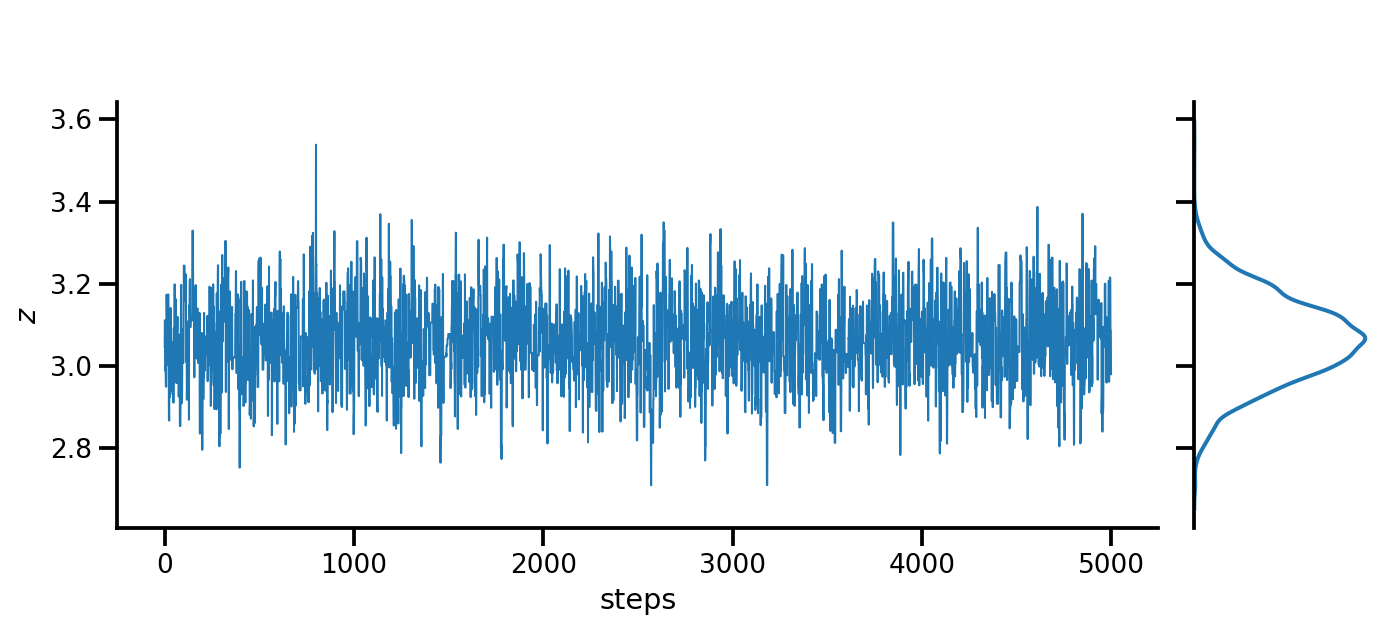

In [9]:
n_burnin = 1000
x, y = np.arange(n_iter-n_burnin), posterior[n_burnin:]

# seabornで複数のプロットを組み合わせるためのクラス
g = sns.JointGrid()
# メインのプロット
sns.lineplot(x=x, y=y, linewidth=1, ax=g.ax_joint)
# y軸に付属するプロット
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)
g.ax_joint.set_xlabel('steps')
g.ax_joint.set_ylabel('$z$')
g.ax_marg_x.set_axis_off()
g.fig.set_figwidth(10)
g.fig.set_figheight(4)

step size = 0.01


  0%|          | 0/4000 [00:00<?, ?it/s]

acceptance ratio: 0.882
step size = 10.0


  0%|          | 0/4000 [00:00<?, ?it/s]

acceptance ratio: 0.017


Text(0, 0.5, 'z')

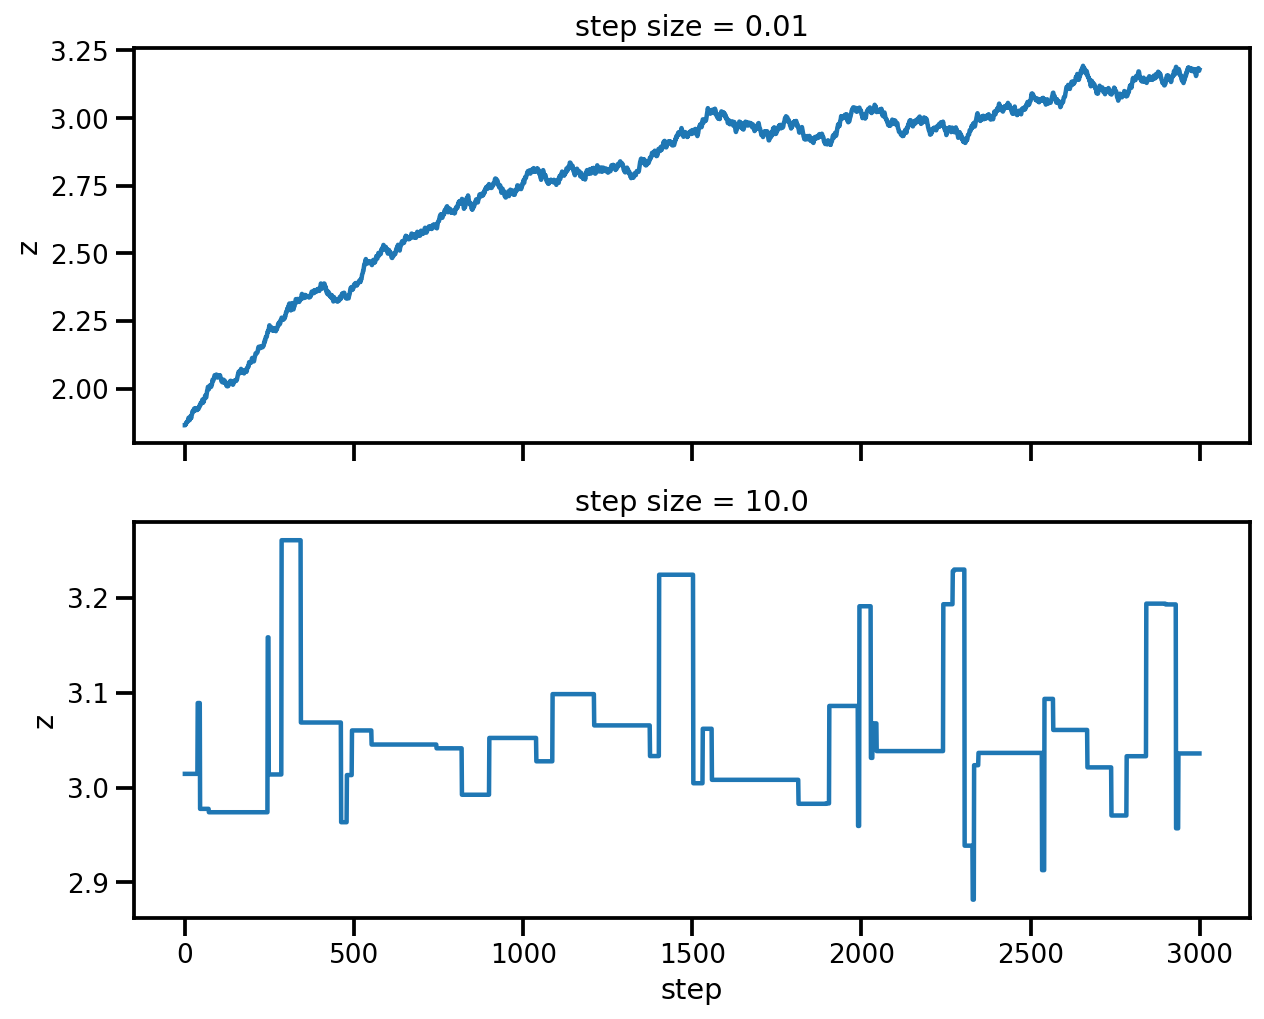

In [10]:
#@title 収束しない例
def randomwalk_MH(x_init, step_size=0.3, n_iter=6000, n_burnin=1000):
    x_current = x_init
    posterior = []
    n_accepted = 0

    for i in tqdm(range(n_iter)):
        x_proposal = x_current + step_size * np.random.uniform(-1, 1)

        r = np.random.rand()
        logp_current = unnormalized_log_posterior(x_current)
        logp_prop = unnormalized_log_posterior(x_proposal)
        if np.exp(logp_prop - logp_current) > r:
            n_accepted += 1
            x_current = x_proposal
        posterior.append(x_current)

    print('acceptance ratio: {:.3f}'.format(n_accepted / n_iter))
    return posterior[n_burnin:]

print('step size = 0.01')
posterior_small_step = randomwalk_MH(0, 0.01, 4000, 1000)

print('step size = 10.0')
posterior_large_step = randomwalk_MH(0, 10, 4000, 1000)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax = axes[0]
ax.plot(posterior_small_step)
ax.set_title('step size = 0.01')
ax.set_ylabel('z')

ax = axes[1]
ax.plot(posterior_large_step)
ax.set_title('step size = 10.0')
ax.set_xlabel('step')
ax.set_ylabel('z')

Text(0, 0.5, 'autocorr')

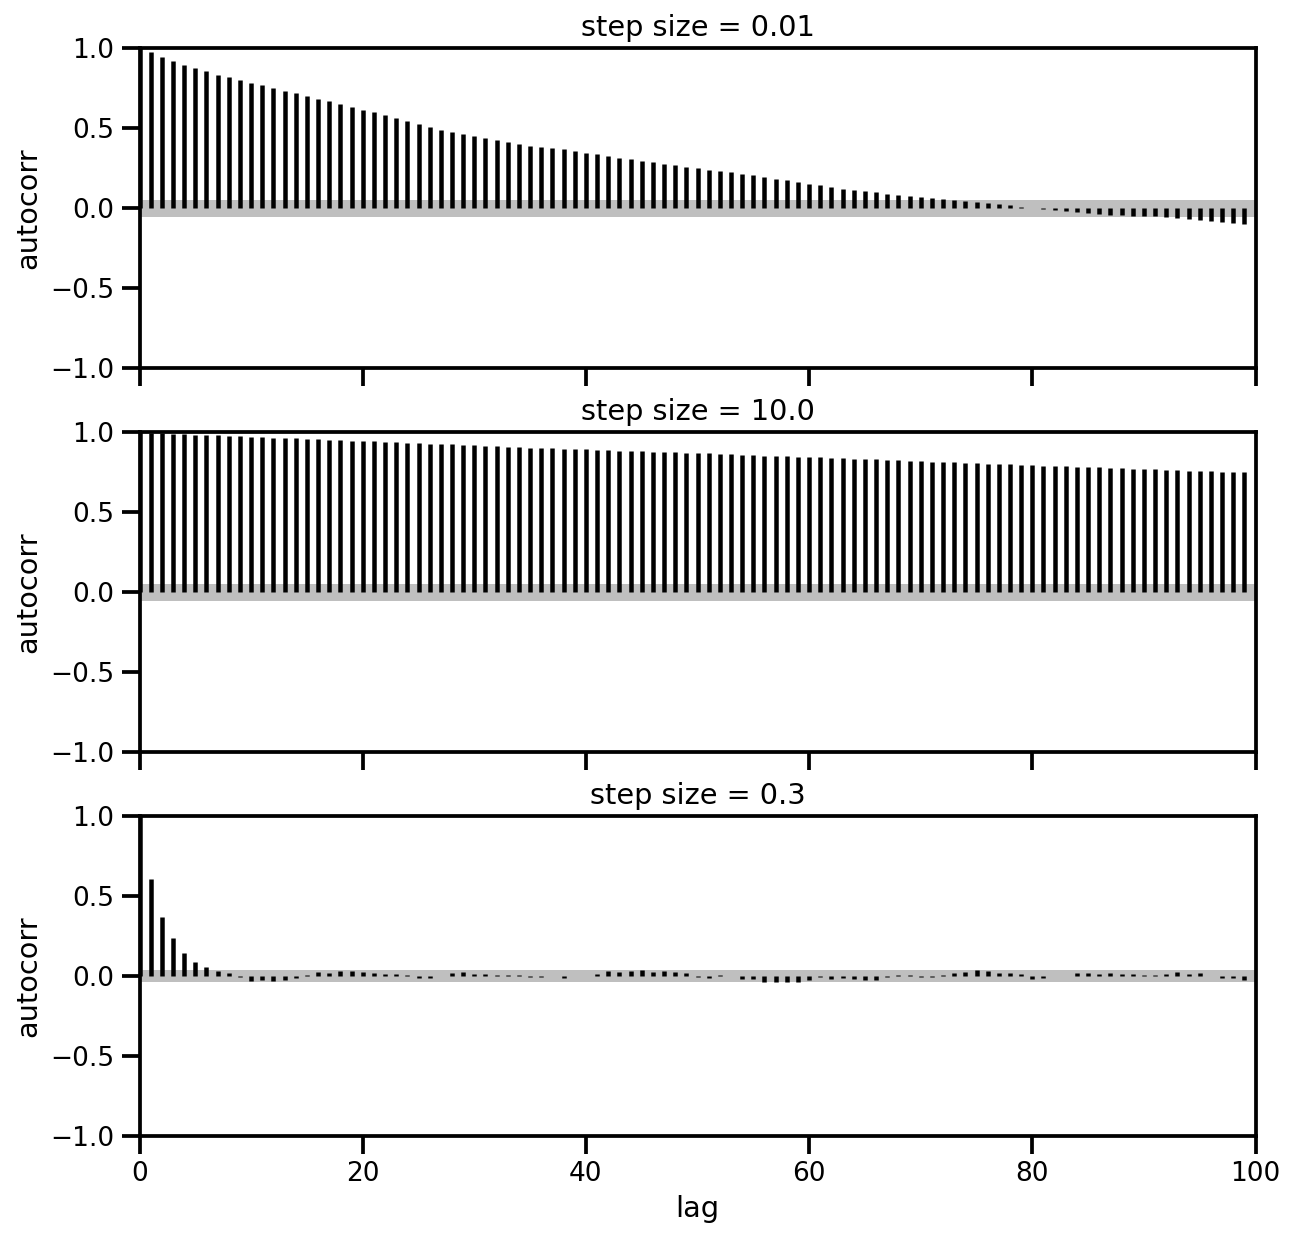

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax = axes[0]
az.plot_autocorr(np.array(posterior_large_step[n_burnin:]), ax=ax)
ax.set_title(f'step size = 0.01')
ax.set_ylabel('autocorr')

ax = axes[1]
az.plot_autocorr(np.array(posterior_small_step[n_burnin:]), ax=ax)
ax.set_title(f'step size = 10.0')
ax.set_ylabel('autocorr')

ax = axes[2]
az.plot_autocorr(np.array(posterior[n_burnin:]), ax=ax)
ax.set_title(f'step size = {step_size}')
ax.set_xlabel('lag')
ax.set_ylabel('autocorr')

  0%|          | 0/6000 [00:00<?, ?it/s]

acceptance ratio: 0.490


  0%|          | 0/6000 [00:00<?, ?it/s]

acceptance ratio: 0.483


  0%|          | 0/6000 [00:00<?, ?it/s]

acceptance ratio: 0.487


Text(0.5, 0, '$z$')

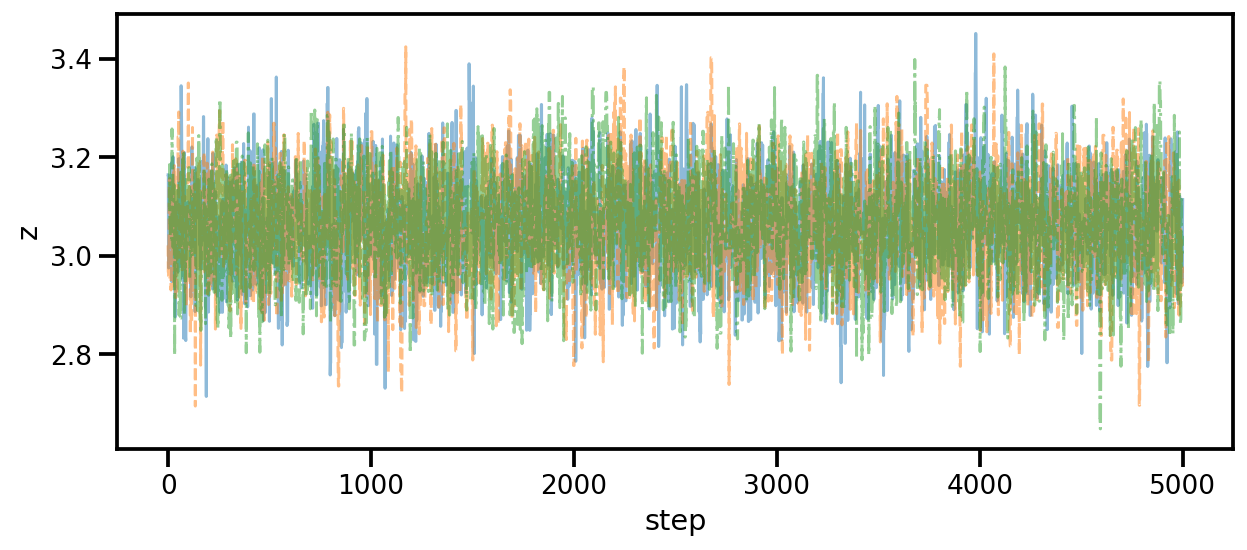

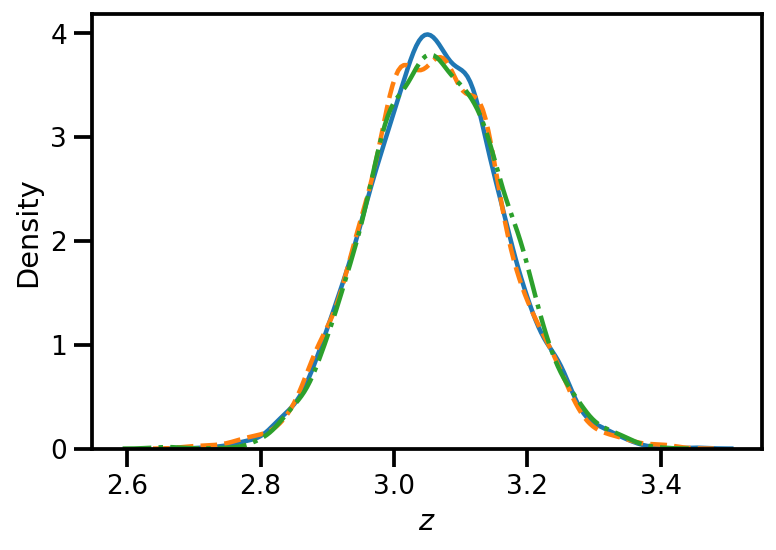

In [12]:
#@title 複数チェーンでのMCMC
np.random.seed(1)
x_inits = np.random.uniform(-1, 1, 3)
posteriors = [randomwalk_MH(x_init) for x_init in x_inits]
posteriors = np.array(posteriors).transpose()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(posteriors[:,0], lw=1.5, alpha=0.5)
ax.plot(posteriors[:,1], lw=1.5, alpha=0.5, ls='--')
ax.plot(posteriors[:,2], lw=1.5, alpha=0.5, ls='-.')
ax.set_xlabel('step')
ax.set_ylabel('z')

fig, ax = plt.subplots()
sns.kdeplot(posteriors[:, 0])
sns.kdeplot(posteriors[:, 1], ls='--')
sns.kdeplot(posteriors[:, 2], ls='-.')
ax.set_xlabel('$z$')

In [13]:
rhat = az.rhat(posteriors.transpose())
print(f'Rhat: {rhat:.3f}')

Rhat: 1.000


true posterior mean: 3.058, sd: 0.100
estimated posterior mean: 3.062, sd: 0.101


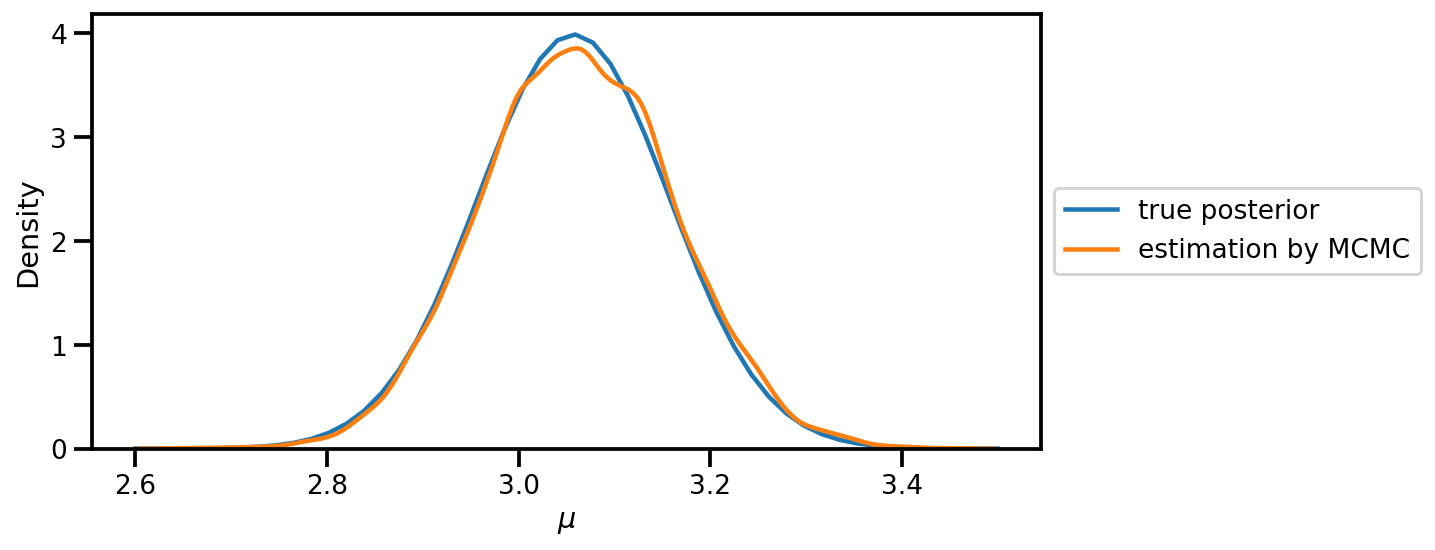

In [14]:
#@title calculate posterior
lam = 1.0
lam_mu = 0.1
m = 0
lam_mu_hat = n_sample*lam + lam_mu
sigma_hat = np.sqrt(1/lam_mu_hat)
m_hat = (lam * data.sum() + lam_mu*m) / lam_mu_hat

posteriors = posteriors.ravel() # 3つのチェーンをまとめる

xx = np.linspace(2.6, 3.5)
fig, ax = plt.subplots(figsize=(8.5, 4))
ax.plot(xx, stats.norm(m_hat, sigma_hat).pdf(xx))
sns.kdeplot(posteriors, ax=ax)
ax.set_xlabel('$\mu$')
ax.legend(['true posterior', 'estimation by MCMC'], 
          loc='center left', 
          bbox_to_anchor=(1.0, 0.5))

print('true posterior mean: {:.3f}, sd: {:.3f}'.format(
    m_hat, sigma_hat))
print('estimated posterior mean: {:.3f}, sd: {:.3f}'.format(
    posteriors.mean(), posteriors.std()))

# 変分推論法

## 変分推論の具体例
書籍では省略していますが、TFPによる変分推論の具体例です。

Text(0, 0.5, 'negative ELBO')

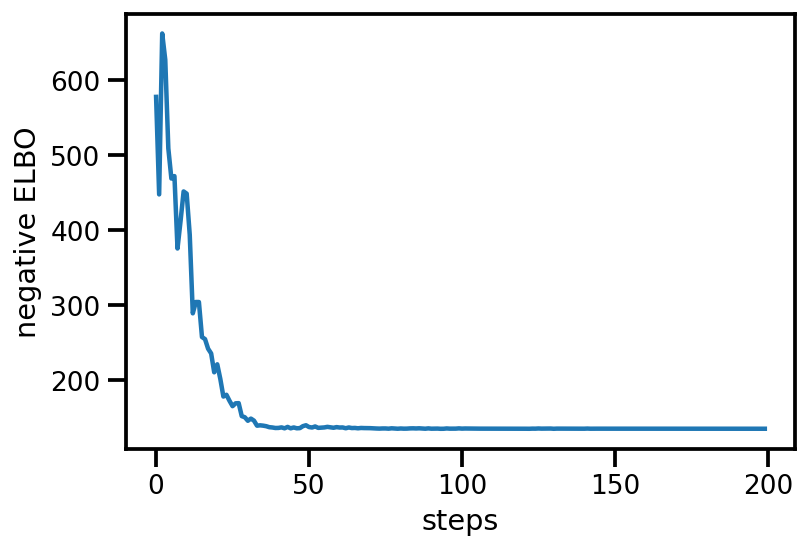

In [15]:
#TFPによる変分推論
tf.random.set_seed(1)

Root = tfd.JointDistributionCoroutine.Root
def model():
    mu = yield Root(tfd.Normal(loc=0, scale=10)) # 事前分布
    y = yield tfd.Sample(
        tfd.Normal(loc=mu, scale=true_sd),
        sample_shape=n_sample)
  
joint = tfd.JointDistributionCoroutine(model)

# yは観測ずみなので予め与えておく。muの正規化されていない事後分布になる。
# iidなサンプルn_sample個の確率の和をとる
def unnormalized_log_posterior(mu):
    return joint.log_prob(mu, data)


q_mu_loc = tf.Variable(0., name='q_mu_loc')
q_mu_scale = tfp.util.TransformedVariable(1., tfb.Softplus(), name='q_mu_scale')
q_mu = tfd.Normal(loc=q_mu_loc, scale=q_mu_scale, name='q_mu')

losses = tfp.vi.fit_surrogate_posterior(
    unnormalized_log_posterior,
    surrogate_posterior=q_mu,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=200,
    sample_size=20,
    seed=1)

plt.plot(losses)
plt.xlabel('steps')
plt.ylabel('negative ELBO')

true posterior mean: 3.058, sd: 0.100
estimated posterior mean: 3.065, sd: 0.109


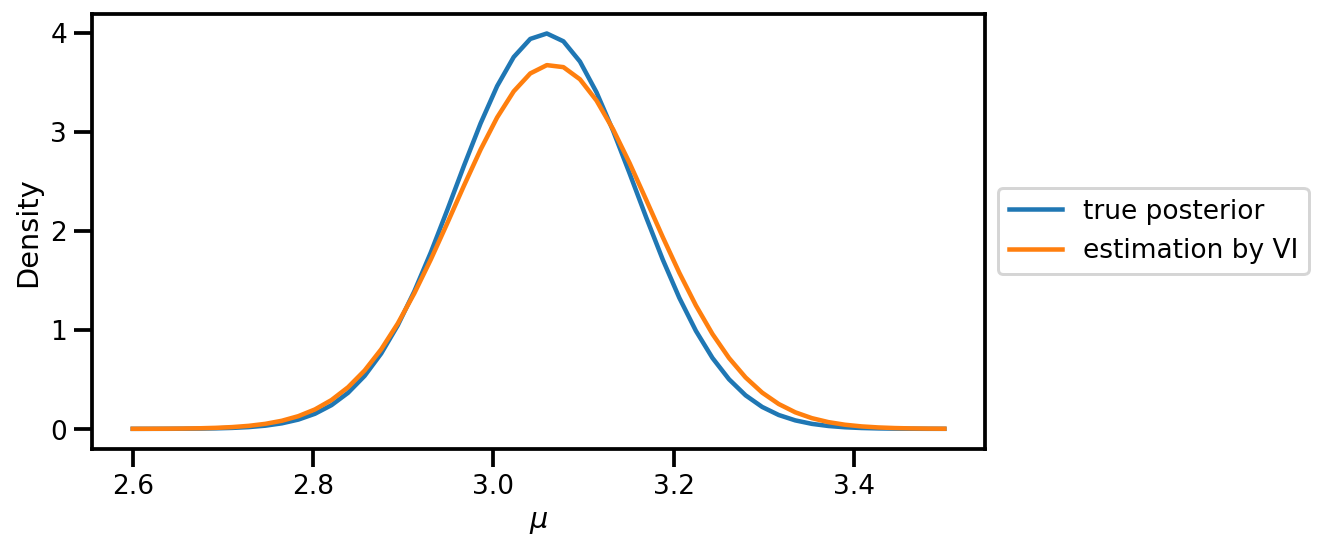

In [16]:
#@title calculate posterior
xx = np.linspace(2.6, 3.5)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(xx, stats.norm(m_hat, sigma_hat).pdf(xx))
ax.plot(xx, stats.norm(q_mu_loc.numpy(), q_mu_scale.numpy()).pdf(xx))
ax.legend(['true posterior', 'estimation by VI'],
          loc='center left', 
          bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('$\mu$')
ax.set_ylabel('Density')

print('true posterior mean: {:.3f}, sd: {:.3f}'.format(
    m_hat, sigma_hat))
print('estimated posterior mean: {:.3f}, sd: {:.3f}'.format(
    q_mu_loc.numpy(), q_mu_scale.numpy()))